In [1]:
import pickle
import numpy as np
import pandas as pd

import torch 

import scipy.stats
from sklearn.manifold import MDS

import tqdm


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.ticker as mtick
import matplotlib.lines as lines


import seaborn as sns

import Bio.Data.IUPACData

import config
import utils
import msa_tools
import plot_utils

In [2]:
@config.memory.cache
def get_msas():
    return utils.map_dict(lambda x: config.get_codon_msa_as_int_array(x, as_torch=False), config.MSA_FILESd)

msas_codon = get_msas() # codon MSAs

WT_NP = config.WT.numpy()
WT_AA_NP = config.WT_AA_TENSOR.numpy()

In [3]:
@config.memory.cache
def get_msa_stats(msa, round_num):
    # convert to amino acid version of msa
    msa_aa = config.CODON_AA_MAP.numpy()[msa]
    msa_aa_wt = msa_tools.MSAwt(msa_aa, WT_AA_NP)

    ret = msa_aa_wt.get_stats_dict() 

    ret["num_unique_dna_seqs"] = np.unique(msa, axis=0).shape[0]

    ret["num_unique_aa_seqs"] = np.unique(msa_aa, axis=0).shape[0]
    ret["avg_aa_dist_from_wt"] = msa_aa_wt.avg_dist_from_wt
    ret["avg_aa_pairwise_dist"] = msa_aa_wt.avg_pairwise_dist
    
    del ret["name"]

    return ret

In [4]:
msa_stats = {f"Round {k}":get_msa_stats(v, k) for k,v in msas_codon.items()}
msa_stats_pd = pd.DataFrame.from_dict(msa_stats)
msa_stats_pd

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 15
num_seqs,10944,9029,6168,11213,6208,121654
seq_length,186,186,186,186,186,186
avg_dist_from_wt_pct,0.45%,0.87%,1.29%,1.57%,1.81%,6.39%
avg_pairwise_dist_pct,0.89%,1.73%,2.54%,3.07%,3.53%,11.12%
optimal_theta_after_mean_removal,0.99,0.99,0.98,0.98,0.97,0.91
optimal_plmc_theta_after_mean_removal,0.01,0.01,0.02,0.02,0.03,0.09
num_unique_dna_seqs,2763,1752,2647,2212,2328,90157
num_unique_aa_seqs,1750,1310,2154,1826,2014,88972
avg_aa_dist_from_wt,0.830775,1.6231,2.40159,2.9242,3.35857,11.8823
avg_aa_pairwise_dist,1.65953,3.22215,4.71772,5.70971,6.56612,20.6903


In [5]:
msa_stats_dists = msa_stats_pd.loc[["avg_dist_from_wt_pct", "avg_pairwise_dist_pct"]].transpose()
msa_stats_dists[["round_num"]] = msa_stats_dists.index.str.split(" ").str[1]
msa_stats_dists_melt = msa_stats_dists.melt(
        value_vars=["avg_dist_from_wt_pct", "avg_pairwise_dist_pct"], id_vars="round_num")
msa_stats_dists_melt.value = msa_stats_dists_melt.value.map(lambda x: float(x.strip("%")))
msa_stats_dists_melt.round_num = msa_stats_dists_melt.round_num.astype(float)
msa_stats_dists_melt

,round_num,variable,value
0,1.0,avg_dist_from_wt_pct,0.45
1,2.0,avg_dist_from_wt_pct,0.87
2,3.0,avg_dist_from_wt_pct,1.29
3,4.0,avg_dist_from_wt_pct,1.57
4,5.0,avg_dist_from_wt_pct,1.81
5,15.0,avg_dist_from_wt_pct,6.39
6,1.0,avg_pairwise_dist_pct,0.89
7,2.0,avg_pairwise_dist_pct,1.73
8,3.0,avg_pairwise_dist_pct,2.54
9,4.0,avg_pairwise_dist_pct,3.07


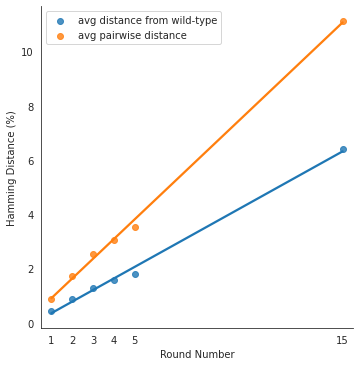

In [6]:
#sns.set(font_scale=1)
with sns.axes_style("white"):


    g = sns.lmplot(data=msa_stats_dists_melt, x="round_num", y="value", hue="variable", ci=None)
    g.set(xlim=(.5, 15.5), xlabel="Round Number", ylabel="Hamming Distance (%)")
    plt.xticks([1,2,3,4,5,15])
    new_labels = ['avg distance from wild-type', 'avg pairwise distance']
    handles = g.legend.legendHandles
    g.legend.remove()
    plt.legend(handles, new_labels)

    pass
plt.savefig(f"{config.ASSETS_DIR}/distances_linear.png", dpi=300)
plot_utils.save_eps_file(f"{config.ASSETS_DIR}/distances_linear.eps")

In [7]:
sns.set_style('darkgrid')

In [8]:
msas_aa = utils.map_dict(lambda x: config.CODON_AA_MAP.numpy()[x], msas_codon)
msa_dist_from_WT = utils.map_dict(lambda m: (m != WT_AA_NP).sum(axis=1), msas_aa)

identifiers = list(msa_dist_from_WT.keys())

def create_dist_from_wt_df(k):
    r = pd.DataFrame.from_dict({"aa_dist":msa_dist_from_WT[k]})
    r["round_num"] = k
    return r

dist_pd = pd.concat([create_dist_from_wt_df(k) for k in msa_dist_from_WT])

In [9]:
dist_pd["type"] = "dist_wt"

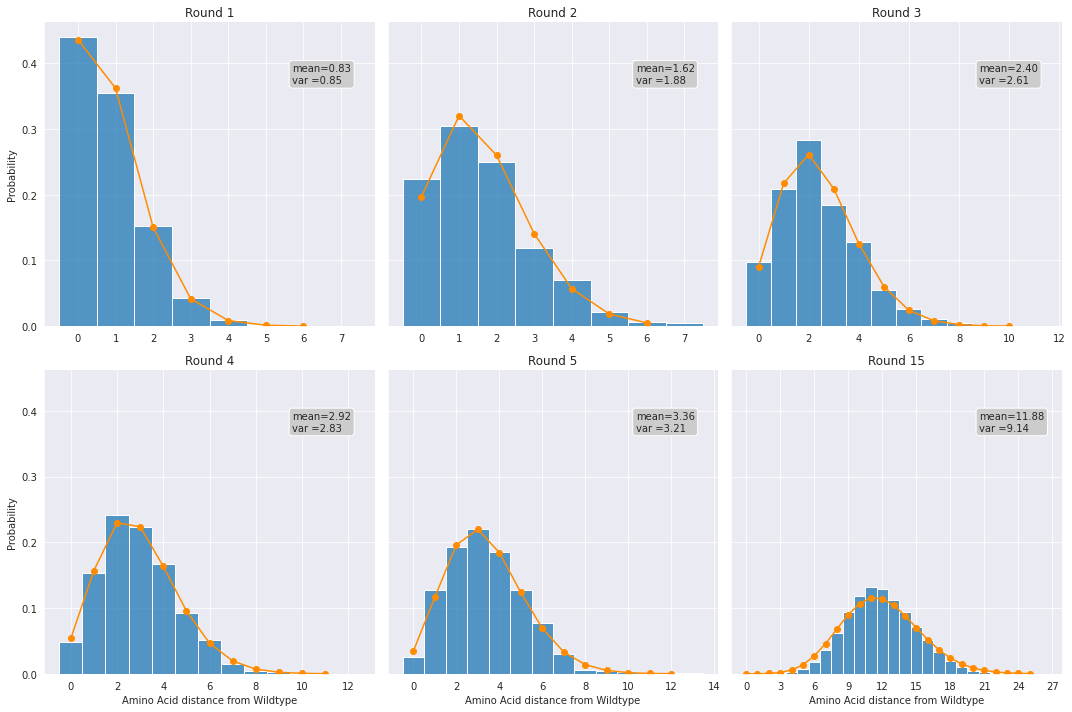

In [10]:
g = sns.displot(dist_pd, col="round_num", x="aa_dist", 
            col_wrap=3, facet_kws ={"sharex":False, "sharey":True}, 
            discrete=True, stat="probability", common_bins=False, common_norm=False)

def plot_poisson(*args, **kwargs):
    dist_array = args[0]
    dist_array_max = dist_array.max()
    lam = dist_array.mean()
    pd = scipy.stats.poisson(lam)
    ax = plt.gca()
    ax.plot(np.arange(dist_array_max), pd.pmf(np.arange(dist_array_max)), 
            marker='o', color="darkorange")
    ax.text(0.75, 0.8, f"mean={dist_array.mean():.2f}\n"
                       f"var ={dist_array.var():.2f}", 
             transform = ax.transAxes, 
             bbox = dict(boxstyle="round", fc="0.8"));

g.map(plot_poisson, "aa_dist")

for k, ax in g.axes_dict.items():
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"Round {k}")
    if k in [1, 4]:
        ax.set_ylabel("Probability")
    if k in [4, 5, 15]:
        ax.set_xlabel("Amino Acid distance from Wildtype")
    
plt.tight_layout()
plt.savefig(f"{config.ASSETS_DIR}/mutation_distribution.png", dpi=300)
#plt.savefig(f"{config.ASSETS_DIR}/mutation_distribution.eps")

In [11]:
def sample_pairwise_distances(msa, num_pairs):
    it = (np.random.choice(msa.shape[0], 2, replace=True)
                    for _ in range(num_pairs))
    return np.array([(msa[x, :] != msa[y, :]).sum() for x, y in it])

def create_pairwise_dist_df(k):
    r = pd.DataFrame.from_dict({"aa_dist":sample_pairwise_distances(msas_aa[k], num_pairs=10000)})
    r["round_num"] = k
    return r

pairwise_dist_pd = pd.concat([create_pairwise_dist_df(k) for k in identifiers])
pairwise_dist_pd["type"] = "pairwise_dist"

In [12]:
all_distances_pd = pd.concat([dist_pd, pairwise_dist_pd])

In [13]:
key_rounds_distances_pd = all_distances_pd[all_distances_pd.round_num.isin([1,3, 5, 15])]

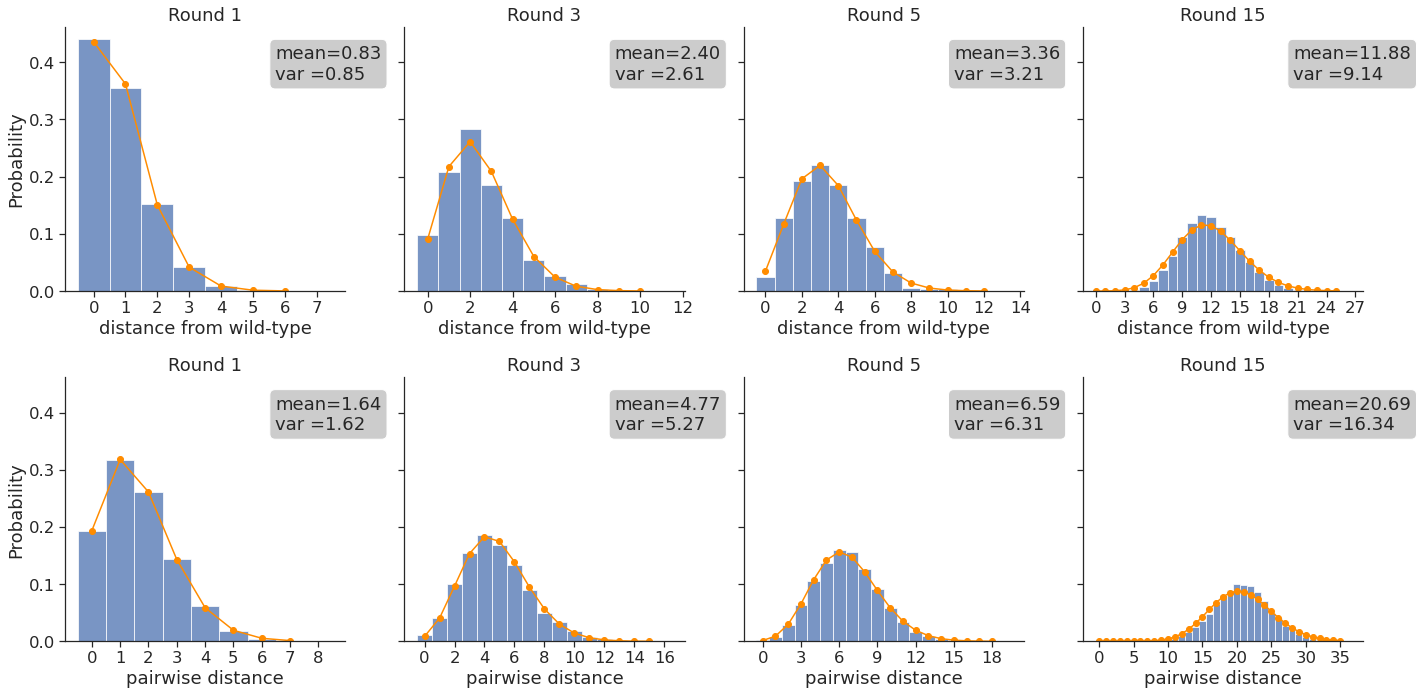

In [14]:
sns.set_theme(style="ticks", font_scale = 1.5)

g = sns.displot(key_rounds_distances_pd, col="round_num", x="aa_dist", row="type", 
                facet_kws ={"sharex":False, "sharey":True}, 
            discrete=True, stat="probability", common_bins=False, common_norm=False)
g.map(plot_poisson, "aa_dist")

for (distance_type, k), ax in g.axes_dict.items():
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"Round {k}")

    if k in [1]:
        ax.set_ylabel("Probability")
    if distance_type == "pairwise_dist":
        ax.set_xlabel("pairwise distance")
        #ax.set_title("")
    else:
        ax.set_xlabel("distance from wild-type")
        
plt.tight_layout()
plt.savefig(f"{config.ASSETS_DIR}/mutation_distribution.png", dpi=300)
#plt.savefig(f"{config.ASSETS_DIR}/mutation_distribution.eps")

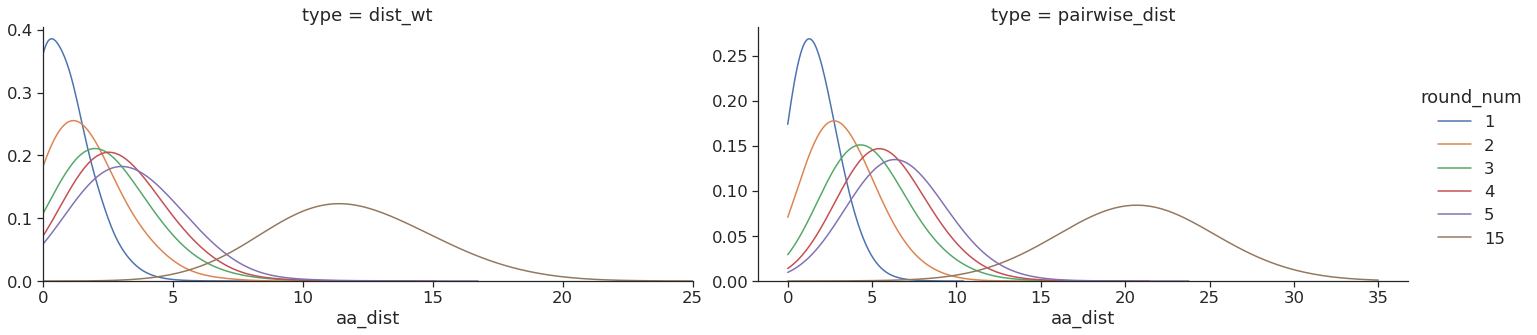

In [15]:
sns.set_theme(style="ticks", font_scale = 1.5)
g = sns.FacetGrid(all_distances_pd, col='type', hue="round_num", aspect=2, height=5, sharex=False, sharey=False)
g.map(sns.kdeplot, 'aa_dist', bw_adjust=4, clip=(0,35))
g.add_legend()
g.axes_dict["dist_wt"].set_xlim(0, 25)
plt.savefig(f"{config.ASSETS_DIR}/mutation_distribution_all.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/mutation_distribution_all.eps")

## Round 15 mutation frequency

In [16]:
avg_muts_by_pos = (msas_aa[15] != WT_AA_NP).mean(axis=0)

In [17]:
muts_by_pos_df = pd.DataFrame({"avg_muts_by_pos":avg_muts_by_pos})
muts_by_pos_df["uniprot_idx"] = muts_by_pos_df.index.astype(int) + 2
muts_by_pos_df

,avg_muts_by_pos,uniprot_idx
0,0.057392,2
1,0.016399,3
2,0.015577,4
3,0.009527,5
4,0.021438,6
...,...,...
181,0.017262,183
182,0.092804,184
183,0.032206,185
184,0.241587,186


In [18]:
muts_by_pos_df.iloc[muts_by_pos_df.avg_muts_by_pos.idxmax()]

avg_muts_by_pos     0.698563
uniprot_idx        20.000000
Name: 18, dtype: float64

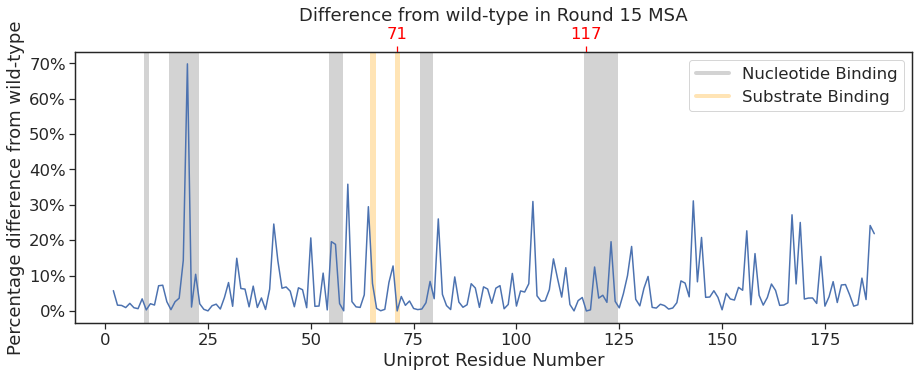

In [19]:

plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='uniprot_idx', y='avg_muts_by_pos', data=muts_by_pos_df)

ax.set_xlabel("Uniprot Residue Number")
ax.set_ylabel("Percentage difference from wild-type")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("Difference from wild-type in Round 15 MSA")

# nucleotide binding in https://www.uniprot.org/uniprot/P00375
for start, end in [(10,10), (16,22), (55,57), (77,79), (117,124)]:
    ax.axvspan(start - 0.5, end + 0.5, color='lightgray')
    
for start, end in [(65,65), (71,71)]:
    ax.axvspan(start - 0.5, end + 0.5, color='moccasin')    
    
legend_lines = [lines.Line2D([0], [0], color="lightgray", lw=4),
                lines.Line2D([0], [0], color="moccasin", lw=4)
               ]
ax.legend(legend_lines, ['Nucleotide Binding', 'Substrate Binding'])

ax_t = ax.twiny()
ax_t.set_xlim(ax.get_xlim())
ax_t.set_xticks([71, 117])
ax_t.tick_params(axis='x', colors='red')


plt.savefig(f"{config.ASSETS_DIR}/Round15_mutation_frequency.png", dpi=300)
plot_utils.save_eps_file(f"{config.ASSETS_DIR}/Round15_mutation_frequency.eps")

pass

In [20]:
def calc_aa_pct(msa_aa):
    msa_one_hot = utils.convert_to_one_hot(msa_aa, q=config.qa)
    aa_pct = msa_one_hot.sum(axis=(0, 1), keepdims=True) / float(msa_one_hot.shape[0]  * config.L)
    return aa_pct.numpy().squeeze()

In [21]:
msas_aa_comp = utils.map_dict(calc_aa_pct, msas_aa)

wt_msa = config.WT_AA_TENSOR.numpy()[np.newaxis, :]
# cannot use utils.convert_to_one_hot because it doesn't work for single dimension MSAs
wt_msa_one_hot = torch.eye(config.qa, dtype=torch.int32)[wt_msa].unsqueeze(0)
wt_aa_pct = wt_msa_one_hot.sum(axis=(0, 1), keepdims=True) / float(config.L)
wt_aa_pct = wt_aa_pct.numpy()

aa_comp_diff = utils.map_dict(lambda x: (x / wt_aa_pct).squeeze(), msas_aa_comp)
#aa_comp_diff

In [22]:
aa_comp_diff_df = pd.DataFrame.from_dict(aa_comp_diff, orient='index') * 100

# name the columns with one-letter-alphabet
aa_comp_diff_df.columns = [config.INV_AA_MAP[x] for x in range(config.qa)]
# sort the columns alphabetically
sorted_aa_list = sorted(list(aa_comp_diff_df.columns))
aa_comp_diff_df = aa_comp_diff_df[sorted_aa_list]
# give 3 letter names to the columns
aa_comp_diff_df.columns = list(map(Bio.Data.IUPACData.protein_letters_1to3.get, aa_comp_diff_df.columns))

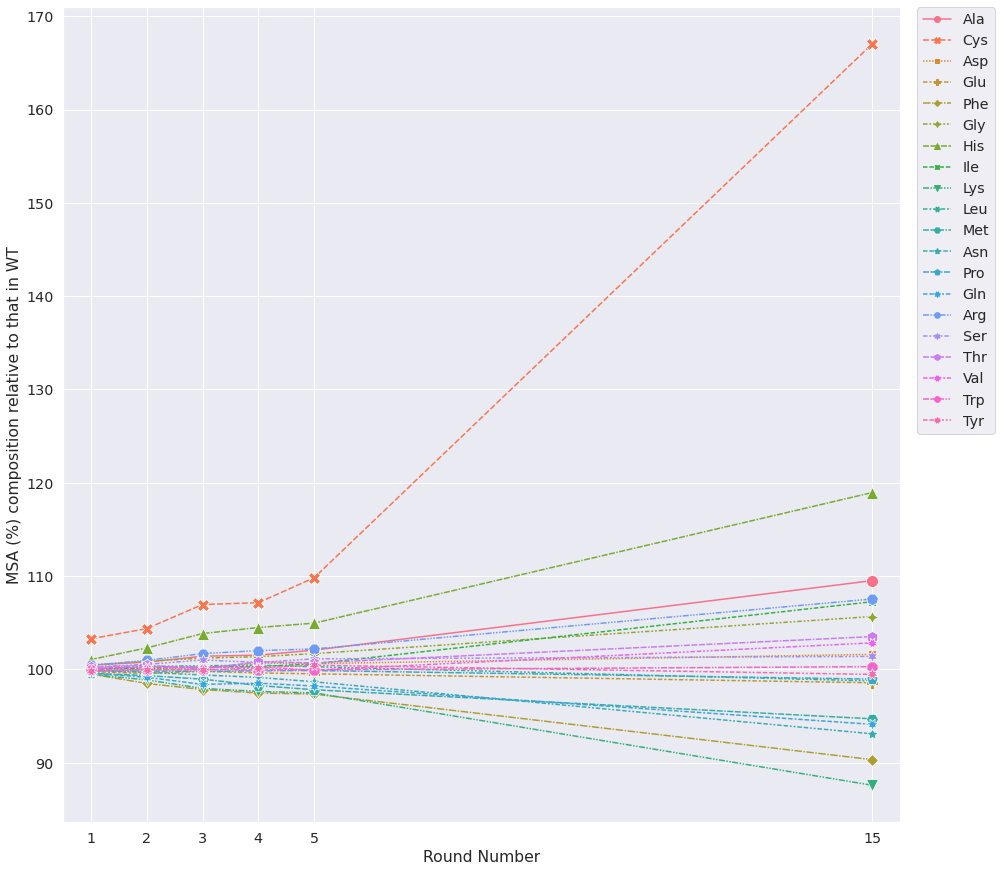

In [38]:
plt.figure(figsize=(15, 15))
g = sns.lineplot(data=aa_comp_diff_df, markers=True, markersize=12)
g.set(xlim=(.5, 15.5), xlabel="Round Number", ylabel="MSA (%) composition relative to that in WT")
plt.xticks([1,2,3,4,5,15])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

pass

In [24]:
aa_comp_diff_df.round(decimals=2)

,Ala,Cys,Asp,Glu,Phe,Gly,His,Ile,Lys,Leu,Met,Asn,Pro,Gln,Arg,Ser,Thr,Val,Trp,Tyr
1,100.46,103.28,100.08,99.76,99.50,100.47,101.06,100.07,99.46,100.08,99.59,99.90,99.85,99.59,100.44,100.26,100.23,100.08,99.98,99.79
2,100.78,104.37,100.03,99.56,98.49,100.87,102.30,100.14,98.88,100.31,99.34,99.69,99.83,99.16,100.96,100.54,100.43,100.27,99.97,99.98
3,101.41,106.96,100.15,99.79,97.84,101.21,103.84,100.27,97.97,100.40,98.96,99.41,99.78,98.39,101.70,101.02,100.05,100.24,99.98,99.95
4,101.53,107.15,100.68,99.63,97.47,101.36,104.49,100.30,97.64,100.45,98.28,99.15,99.85,98.53,102.01,100.75,100.82,100.22,99.95,100.17
5,102.06,109.83,100.62,99.53,97.36,101.70,104.96,100.60,97.49,100.29,97.82,98.67,99.88,98.22,102.19,101.13,100.70,99.92,99.96,100.45
15,109.51,167.02,101.61,98.57,90.33,105.67,118.95,107.25,87.59,98.77,94.71,93.10,98.96,94.11,107.55,101.39,103.52,102.85,100.30,99.47


## Latent space plot

In [25]:
with open("../DHFR/plot/mDHFR_clean_latent.pkl", "rb") as fh:
    natural_latent = pickle.load(fh)
with open("../DHFR/plot/Gen15_latent.pkl", "rb") as fh:
    gen15_latent = pickle.load(fh)

In [26]:
np_natural_latent = natural_latent["background_latent"]

In [27]:
np_gen15_latent = gen15_latent["means"]

In [28]:
np_gen15_latent.shape

(127110, 2)

In [29]:
np.random.seed(100)
subsample_size = 5000
idx = np.random.choice(np_gen15_latent.shape[0], subsample_size, replace=False )
np_gen15_latent_subsample = np_gen15_latent[idx, :]

In [30]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [31]:
wt_latent = np_natural_latent[-1, :] # the WT seq is the last one
wt_latent_x, wt_latent_y = wt_latent

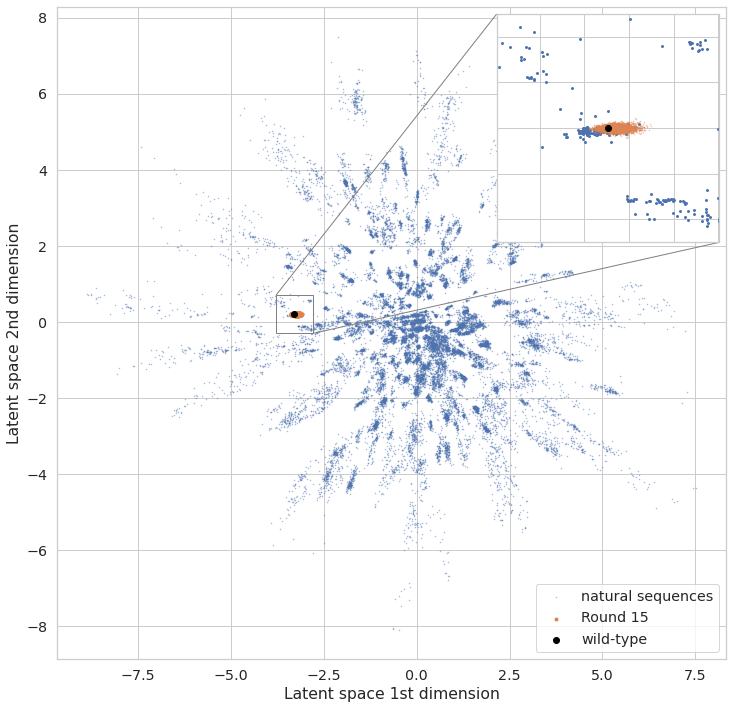

In [32]:
sns.set_theme()
sns.set(font_scale = 1.3, style="whitegrid")


fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.scatter(np_natural_latent[:, 0], np_natural_latent[:, 1], 
           s=1, marker=".", alpha=0.5, label="natural sequences")
ax.set_xlabel("Latent space 1st dimension")
ax.set_ylabel("Latent space 2nd dimension")
ax.scatter(np_gen15_latent_subsample[:, 0], np_gen15_latent_subsample[:, 1], 
           marker=".", label="Round 15")
ax.scatter(wt_latent_x, wt_latent_y, marker="o", color="black", label="wild-type")


ax = plt.gca()

axins = zoomed_inset_axes(ax, 6, loc=1) # zoom = 6
axins.scatter(np_natural_latent[:, 0], np_natural_latent[:, 1], 
              s=15, marker=".")
axins.scatter(np_gen15_latent_subsample[:, 0], np_gen15_latent_subsample[:, 1], 
              s=1, marker=".", label="Round 15", alpha=0.5)
axins.scatter(wt_latent_x, wt_latent_y, marker="o", color="black", label="wild-type")


# sub region of the original image
spacer_wt_x = spacer_wt_y = 0.5
x1, x2,  = wt_latent_x - spacer_wt_x, wt_latent_x + spacer_wt_x
y1, y2 = wt_latent_y - spacer_wt_y, wt_latent_y + spacer_wt_y
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=False)
plt.yticks(visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

#fig.suptitle("Latent space of natural sequences and Round 15")
ax.legend(loc="lower right")
#fig.tight_layout()

plt.savefig(f"{config.ASSETS_DIR}/DHFR_latent_space.png", dpi=300)
plot_utils.save_eps_file(f"{config.ASSETS_DIR}/DHFR_latent_space.eps")

pass


## Designed sequences

In [33]:
designs = pd.read_csv("../working/DHFR_incl_main_kit_taq_mse_designed.csv")
designs = designs[:-1].copy() # drop the last design as it is a duplicate (to signal that the design process stops)

designs["activity"] = "no"
designs.loc[0, "activity"] = "yes"
designs.loc[1, "activity"] = "yes"


designs

,seq,round_num,energy,natural_energy,dist_WT,dist_common,dist_msa15,dist_prev,activity
0,VRPLNCIVAVSQNMGIGKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,0,0.786270,-490.657739,10,0,0,0,yes
1,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,1,0.781615,-479.709964,12,2,2,2,yes
2,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,2,0.778994,-470.462492,14,4,4,2,no
3,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,3,0.776915,-460.427448,16,6,6,2,no
4,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,4,0.775064,-456.275702,18,8,8,2,no
5,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,5,0.773416,-446.113990,20,10,10,2,no
6,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,6,0.771807,-439.838341,22,12,12,2,no
7,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,7,0.770479,-441.243086,23,14,14,2,no
8,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,8,0.769250,-440.732868,25,16,16,2,no
9,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTIGSVEGK...,9,0.768139,-442.572899,27,18,18,2,no


In [34]:
designs_ordered = pd.read_csv("../working/DHFR_incl_main_kit_taq_mse_designed_order.csv")

list(designs_ordered.round_num)

[1, 2, 3, 4, 5, 7, 9, 11, 13, 15]

In [35]:
designs["ordered"] = designs.round_num.isin(designs_ordered.round_num)
designs.loc[0, "ordered"] = True # most common sequence is tested

In [36]:
designs_melt = pd.melt(designs[designs.ordered == True], id_vars=["seq", "round_num", "activity"], 
                       value_vars=["dist_WT", "dist_common", "dist_msa15"])
designs_melt.head()

,seq,round_num,activity,variable,value
0,VRPLNCIVAVSQNMGIGKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,0,yes,dist_WT,10
1,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,1,yes,dist_WT,12
2,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,2,no,dist_WT,14
3,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,3,no,dist_WT,16
4,VRPLNCIVAVSQNMGIAKDGDLPWPPLRNEFKYFQRMTTTGSVEGK...,4,no,dist_WT,18


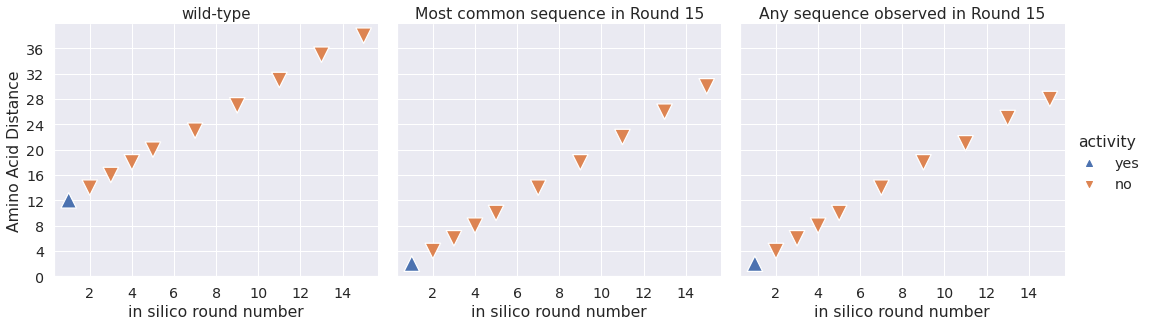

In [37]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)

g = sns.relplot(data=designs_melt[designs_melt.round_num != 0], 
                x="round_num", y="value", col="variable", hue="activity",
         style="activity", markers={"yes":"^", "no":"v"}, s=48*5,
            facet_kws={"sharey":True})

for k, ax in g.axes_dict.items():
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"Round {k}")
    ax.set_ylim(bottom=0)
    if k == "dist_WT":
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel("Amino Acid Distance")
        ax.set_title("wild-type", fontsize=15)
    elif k == "dist_common":
        ax.set_title("Most common sequence in Round 15")
    elif k == "dist_msa15":
        ax.set_title("Any sequence observed in Round 15")
    ax.set_xlabel("in silico round number")


plt.subplots_adjust(top=0.85, bottom=0.15, left=0.05)

#plt.suptitle("Distances of in silico extrapolated sequences from given sequence(s)")

#plt.tight_layout()
plt.savefig(f"{config.ASSETS_DIR}/DHFR_designed_distances.png", dpi=300)
plt.savefig(f"{config.ASSETS_DIR}/DHFR_designed_distances.eps")